# SIIM COVID-19 Detection - a simple EDA 🦠🩺
<a href="https://www.kaggle.com/tanlikesmath/siim-covid-19-detection-a-simple-eda">Notebook リンク</a>

# Imports

In [1]:
!pip install gdcm # DICOM画像のロードみたいな

     |████████████████████████████████| 2.7 MB 1.2 MB/s eta 0:00:01     |█████████▍                      | 798 kB 1.2 MB/s eta 0:00:02


In [2]:
import numpy as np #線形代数
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pydicom #DICOM画像のアンパッキング
import glob
from tqdm.notebook import tqdm #for文でバーが出るバージョン
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt #グラフ線画
from skimage import exposure
import cv2 # 画像の処理
from fastai.vision.all import *
from fastai.medical.imaging import *
import warnings
warnings.filterwarnings('ignore')

# A look at the provided data

Let's check what data is available to us:

In [1]:
dataset_path = Path('../input/siim-covid19-detection')

In [4]:
dataset_path.ls()

(#5) [Path('../input/siim-covid19-detection/sample_submission.csv'),Path('../input/siim-covid19-detection/train_image_level.csv'),Path('../input/siim-covid19-detection/test'),Path('../input/siim-covid19-detection/train'),Path('../input/siim-covid19-detection/train_study_level.csv')]

# A look at the CSVs

Let's check the `train_study_level.csv` file:

In [5]:
train_study_df = pd.read_csv(dataset_path/'train_study_level.csv')

In [6]:
train_study_df.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


As you can see, at the study-level, we are predicting the following classes:
* Negative for Pneumonia 肺炎が陰性かどうか
* Typical Appearance よくわからん
* Indeterminate Appearance よくわからん
* Atypical Appearance よくわからん

This here is a standard multi-label classification problem.

Let's now look at `train_image_level.csv`:

In [8]:
train_image_df = pd.read_csv(dataset_path/'train_image_level.csv')

In [9]:
train_image_df.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e


label の表記について
`[class ID] [confidence score] [bounding box]`

* class ID - either `opacity` or `none`
* confidence score - NNモデルの信頼値．あったら0，なかったら1
* bounding box - typical `xmin ymin xmax ymax` format. If class ID is none, the bounding box is `1 0 0 1 1`.

バウンディングボックスも`ボックス`列に読みやすい辞書形式で提供され、各画像が含まれるスタディは`StudyInstanceUID`で提供される。（よくわからん）

Let's quick look at the distribution of opacity vs none:

<AxesSubplot:>

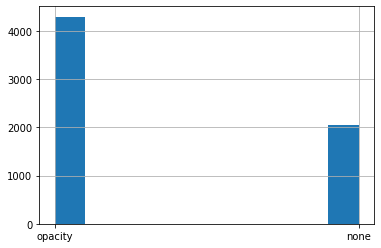

In [10]:
train_image_df['class'] = train_image_df.label.apply(lambda x: x.split()[0])
train_image_df['class'].hist()
# opacityかnoneかどうか

In [11]:
# DataFrameの各行・各列に適用: apply()
#信頼度はとりま置いとく
train_image_df['x_min'] = train_image_df.label.apply(lambda x: float(x.split()[2]))#x_min
train_image_df['y_min'] = train_image_df.label.apply(lambda x: float(x.split()[3]))#y_min
train_image_df['x_max'] = train_image_df.label.apply(lambda x: float(x.split()[4]))#x_max
train_image_df['y_max'] = train_image_df.label.apply(lambda x: float(x.split()[5]))#y_ma

Let's also look at the distribution of the bounding box areas:

<AxesSubplot:>

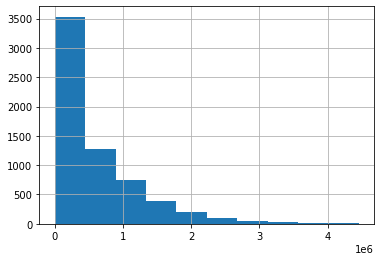

In [12]:
#バウンディングボックスの面積?
def get_bbox_area(row):
    return (row['x_max']-row['x_min'])*(row['y_max']-row['y_min'])


train_image_df['bbox_area'] = train_image_df.apply(get_bbox_area, axis=1)
train_image_df['bbox_area'].hist()

In [13]:
train_image_df.head()

,id,boxes,label,StudyInstanceUID,class,x_min,y_min,x_max,y_max,bbox_area
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,opacity,789.28836,582.43035,1815.94498,2499.73327,1.968412e+06
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,none,0.00000,0.00000,1.00000,1.00000,1.000000e+00
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,opacity,677.42216,197.97662,1545.21983,1197.75876,8.676086e+05
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,opacity,2729.00000,2181.33331,3677.00012,2785.33331,5.725921e+05
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,opacity,623.23328,1050.00000,1337.23328,2156.00000,7.896840e+05


# A look at the images

Okay, let's now look at some example images:

In [14]:
#DICOM画像を配列に変換(そのまま)
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data
        
    
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

#必要なのはリスト型の画像array
def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

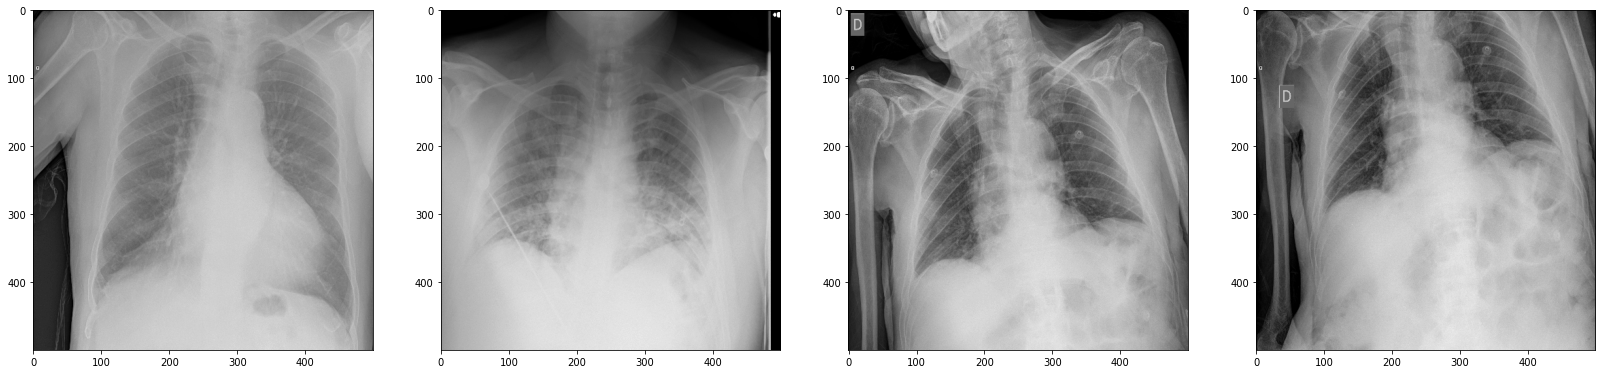

In [15]:
dicom_paths = get_dicom_files(dataset_path/'train')#dicomファイルの取得
imgs = [dicom2array(path) for path in dicom_paths[:4]]#ファイルの4番目まで配列にしてリストにまとめる
plot_imgs(imgs)

Let's actually look at how many images are available per study:

In [16]:
num_images_per_study = []
for i in (dataset_path/'train').ls():
    num_images_per_study.append(len(get_dicom_files(i)))#実験ごとに何枚のdicomファイルがあるか
    if len(get_dicom_files(i)) > 5:#五枚以上なら報告
        print(f'Study {i} had {len(get_dicom_files(i))} images')
    

Study ../input/siim-covid19-detection/train/8943d1d85097 had 6 images
Study ../input/siim-covid19-detection/train/0fd2db233deb had 9 images
Study ../input/siim-covid19-detection/train/a7335b2f9815 had 7 images


(array([5.822e+03, 2.070e+02, 1.500e+01, 4.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

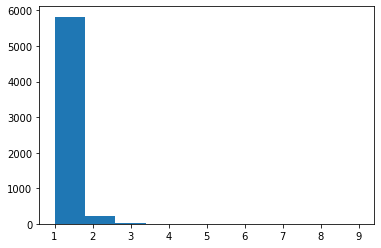

In [17]:
plt.hist(num_images_per_study)

In [18]:
def image_path(row):
    study_path = dataset_path/'train'/row.StudyInstanceUID#実験名でパスを作成
    for i in get_dicom_files(study_path):実験内のDICOM画像を取得
        if row.id.split('_')[0] == i.stem: return i 
        
train_image_df['image_path'] = train_image_df.apply(image_path, axis=1)

In [19]:
train_image_df.head()

,id,boxes,label,StudyInstanceUID,class,x_min,y_min,x_max,y_max,bbox_area,image_path
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,opacity,789.28836,582.43035,1815.94498,2499.73327,1.968412e+06,../input/siim-covid19-detection/train/5776db0cec75/81456c9c5423/000a312787f2.dcm
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,none,0.00000,0.00000,1.00000,1.00000,1.000000e+00,../input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,opacity,677.42216,197.97662,1545.21983,1197.75876,8.676086e+05,../input/siim-covid19-detection/train/9d514ce429a7/22897cd1daa0/0012ff7358bc.dcm
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.00012, 'height': 604}]",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,opacity,2729.00000,2181.33331,3677.00012,2785.33331,5.725921e+05,../input/siim-covid19-detection/train/28dddc8559b2/4d47bc042ee6/001398f4ff4f.dcm
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'height': 1106}, {'x': 2578.56661, 'y': 998.66667, 'width': 662.66667, 'height': 1120}]",opacity 1 623.23328 1050 1337.23328 2156 opacity 1 2578.56661 998.66667 3241.23328 2118.66667,dfd9fdd85a3e,opacity,623.23328,1050.00000,1337.23328,2156.00000,7.896840e+05,../input/siim-covid19-detection/train/dfd9fdd85a3e/49170afa4f27/001bd15d1891.dcm


../input/siim-covid19-detection/train/c85b74b2f14d/c5523075c1bc/73df6b5190c2.dcm
../input/siim-covid19-detection/train/9e61d18ded2f/d4728727fd4d/8d030d8cb033.dcm
../input/siim-covid19-detection/train/78909b4d3179/1c0f46d3a53a/8d1b3efffbbb.dcm
../input/siim-covid19-detection/train/2ea7b438ec6e/3cc9ec62e1f0/23b9a2b1efa0.dcm
../input/siim-covid19-detection/train/1c88dbf27747/b6b5a6522dfb/a7e5d6de0277.dcm
../input/siim-covid19-detection/train/eaac01660339/55abf9c4ae88/63fdf99db501.dcm
../input/siim-covid19-detection/train/ae601aa924ea/cc7139212a24/f6d193531784.dcm
../input/siim-covid19-detection/train/f028f4a45ccd/bcf983bcfefb/6383b7733435.dcm


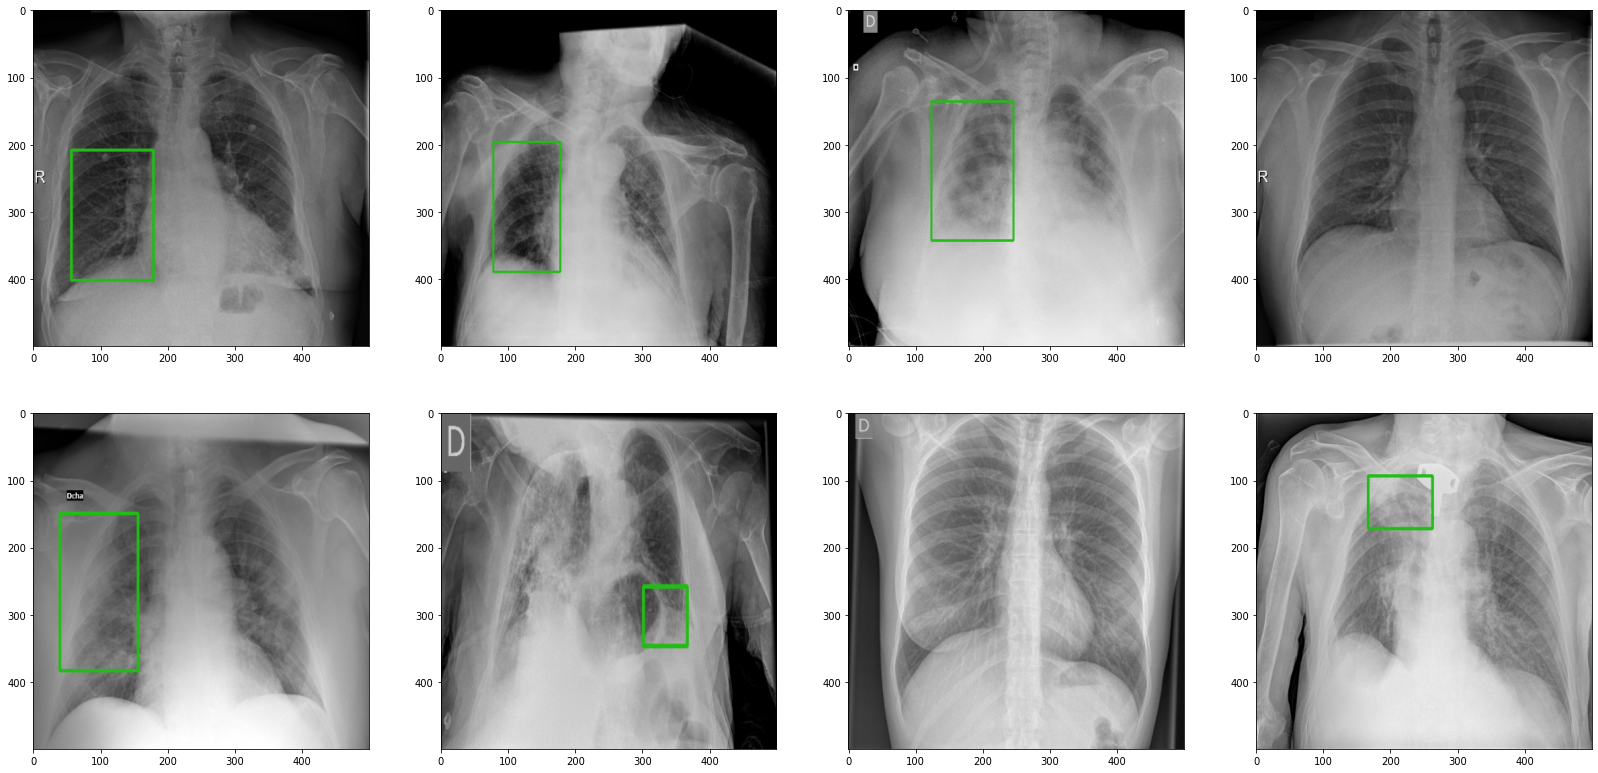

In [24]:
imgs = []
image_paths = train_image_df['image_path'].values
class_ids = train_image_df['class']

# map label_id to specify color
label2color = {class_id:[random.randint(0,255) for i in range(3)] for class_id in class_ids}# Classによってマスクの色をランダム(2つだけ)
thickness = 3 #厚さ
scale = 5


for i in range(8):
    image_path = random.choice(image_paths)
    print(image_path)
    img = dicom2array(path=image_path)#画像ロード
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)#サイズを1/5に縮小.
    img = np.stack([img, img, img], axis=-1)
    
    box = train_image_df.loc[train_image_df['image_path'] == image_path, ['x_min', 'y_min', 'x_max', 'y_max']].values[0]/scale
    label = train_image_df.loc[train_image_df['image_path'] == image_path, ['class']].values[0][0]
    
    color = label2color[label]
    #長方形作図
    img = cv2.rectangle(
        img,
        (int(box[0]), int(box[1])),
        (int(box[2]), int(box[3])),
        color, thickness)
    
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

That's it for now!

**Please upvote if you found this helpful!**